<a href="https://colab.research.google.com/github/subhajitphy/ML_probs/blob/main/cgws_pinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
from astropy.constants import GM_sun, c, pc
#from torchdiffeq import odeint

# Constants
GM_sun, c, pc = GM_sun.value, c.value, pc.value
dsun, tsun = GM_sun/(c**2), GM_sun/(c**3)
yr = 365.25 * 24 * 3600
tsun, yr = torch.tensor(tsun), torch.tensor(yr)

In [3]:
def f_rhs(omg,m_chirp,eta,chi_A,chi_S):
  m_total=m_chirp/eta**(3/5)
  nu=1
  delta=torch.sqrt(1-4*eta)
  tN_omg = tsun * m_chirp * omg  #post-Newtonian relation
  tm_omg = tsun * m_total * omg  #post-Newtonian relation
  Q_15=(-113/12*chi_A*delta+19/3*chi_S*eta-113/12*chi_S+4*torch.pi)
  return ((96/5) * omg**2 * tN_omg**(5/3) * (1 + (-743/336 - (11/4)*eta) * tm_omg**(2/3) * nu
          + Q_15 * tm_omg * nu**(3/2) + (34103/18144 + (13661/2016)*eta
          + (59/18)*eta**2) * tm_omg**(4/3) * nu**2))

In [4]:
num_points = 10000
t_span = torch.linspace(0, 10*yr, num_points, dtype=torch.float64)

omg_a, m_c, eta, nu, chi_A, chi_S = map(
    lambda x: torch.tensor(x, dtype=torch.float64),
    [5e-7, 1e9, 1/4, 1.0, 0.4, 0.5]
)


In [5]:
f_rhs(omg_a,m_c,eta,chi_A,chi_S)

tensor(2.0711e-16, dtype=torch.float64)

In [6]:
def get_omg(t,t_a,omg_a,m_c,eta,nu,chi_A,chi_S):
    m=m_c/eta**(3/5)
    tN_ = m_c*omg_a*tsun
    tm_ = m*omg_a*tsun
    tmta_ = t-t_a
    delta=torch.sqrt(1-4*eta)
    tau = 1-256/5*omg_a*tN_**(5/3)*tmta_
    Q15=(-113/12*chi_A*delta+19/3*chi_S*eta-113/12*chi_S+4*torch.pi)
    ww=(omg_a*(((371/128*eta**2+56975/16128*eta+1855099/903168)/tau**(7/8)+(-3058673/
    1354752-617/192*eta**2-5429/1344*eta)/tau**(11/8)+(-605/192*eta**2-40865/8064*eta-\
    2760245/1354752)/tau**(13/8)+(1331/384*eta**2+89903/16128*eta+6072539/2709504)/
    tau**(19/8))*tm_**(4/3)*nu**2+(3/5/tau**(11/8)*Q15-3/5/tau**(3/4)*Q15)*tm_*nu**(3/2)+
    ((11/8*eta+743/672)/tau**(5/8)+(-11/8*eta-743/672)/tau**(11/8))*tm_**(2/3)*nu+1/
    tau**(3/8)))
    return ww

In [7]:
omg_arr=get_omg(t_span,0,omg_a,m_c,eta,nu,chi_A,chi_S)

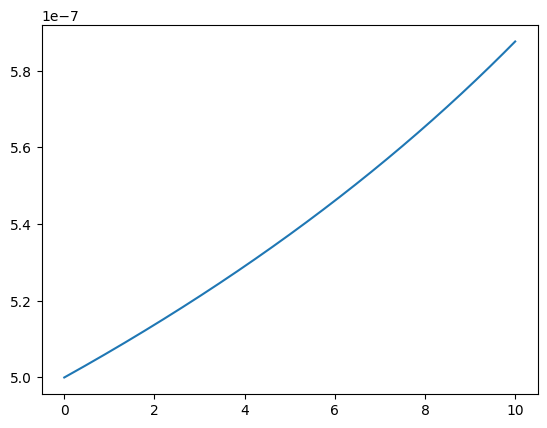

In [8]:
plt.plot(t_span/yr,omg_arr)

In [9]:
num_points = 5000
t_span = torch.linspace(0, 10*yr, num_points, dtype=torch.float64)
omg_arr = get_omg(t_span, 0, omg_a, m_c, eta, nu, chi_A, chi_S)

# Normalize time for stability
t_min, t_max = t_span.min(), t_span.max()
t_scale = (t_max - t_min)   # chain rule factor
t_obs = ((t_span - t_min) / t_scale).reshape(-1,1)
omg_obs = omg_arr.reshape(-1,1)

In [10]:
class PINN(nn.Module):
    def __init__(self, width=64, depth=4):
        super().__init__()
        layers = [nn.Linear(1, width), nn.Tanh()]
        for _ in range(depth-1):
            layers += [nn.Linear(width, width), nn.Tanh()]
        layers += [nn.Linear(width, 1)]
        self.net = nn.Sequential(*layers)
        # Choose activation for output: exp or softplus
        self.softplus = nn.Softplus(beta=2.0)
        self.double()  # ensure parameters are float64

    def forward(self, x):
        # Use exp if you want strict positivity but allow more curvature,
        # or softplus for smoother control
        return self.softplus(self.net(x))
        # return torch.exp(self.net(x))   # alternative


In [11]:
def time_derivative_phys(model, t_norm):
    """
    Compute ω(t) and its derivative dω/dt in *physical* time units
    from a model trained on *normalized* time t_norm ∈ [0,1].

    Why this is needed:
    - In PINNs, we often normalize time (and other inputs) to improve
      training stability and conditioning of the network.
    - Autograd will give us the derivative dω/dτ with respect to the
      *normalized* time variable τ = (t - t_min) / (t_max - t_min).
    - But the physics ODE f_rhs(ω) is written in terms of the *physical*
      time variable t (seconds, years, etc.), so we must convert:
        dω/dt = (dω/dτ) * (dτ/dt)
      And since τ = (t - t_min) / t_scale, we have:
        dτ/dt = 1 / t_scale  ⇒  dω/dt = (dω/dτ) / t_scale
    """

    # Ensure autograd tracks t_norm so it can compute the derivative w.r.t. it
    t_norm.requires_grad_(True)

    # Forward pass: predict ω(τ) from normalized time input
    omega = model(t_norm)

    # Autograd: compute dω/dτ (derivative w.r.t. normalized time variable)
    (domega_dtau,) = torch.autograd.grad(
        outputs=omega,             # function output
        inputs=t_norm,             # variable to differentiate w.r.t.
        grad_outputs=torch.ones_like(omega),  # backprop seed (same shape as omega)
        create_graph=True,         # keep graph for higher-order derivatives if needed
        retain_graph=True          # retain graph for multiple autograd calls
    )

    # Convert derivative from normalized time (τ) to physical time (t)
    # This is the chain rule correction:
    #   domega/dt = domega/dτ / t_scale
    # Here t_scale = (t_max - t_min) in *physical* time units
    domega_dt = domega_dtau / t_scale

    # Return both ω(t) and dω/dt in *physical* time units
    return omega, domega_dt


In [12]:
model = PINN(width=64, depth=4)
opt   = optim.Adam(model.parameters(), lr=2e-3)
w_phy, w_data, w_ic = 0, 1, 0
omega0_known = omg_obs[:1].detach()
#t_colloc = torch.linspace(0, 1, 200, dtype=torch.float64).reshape(-1,1)

In [13]:
# # Just check initial model predictions before training
# with torch.no_grad():
#     omega_pred_init = model(t_obs)
#     print("Initial model output shape:", omega_pred_init.shape)
#     print("First 5 predictions:", omega_pred_init[:5].flatten().cpu().numpy())
#     print("First 5 observed:", omg_obs[:5].flatten().cpu().numpy())
#     print("Initial MSE data loss:", ((omega_pred_init - omg_obs)**2).mean().item())


In [14]:
omega0_known

tensor([[5.0000e-07]], dtype=torch.float64)

In [15]:
def compute_losses():
    omega_c, domega_dt_c = time_derivative_phys(model, t_obs)
    rhs_c = f_rhs(omega_c, m_c, eta, chi_A, chi_S)
    loss_phy = ((domega_dt_c - rhs_c)**2).mean()

    loss_data = ((model(t_obs) - omg_obs)**2).mean()
    loss_ic   = ((model(torch.zeros_like(t_obs[:1])) - omega0_known)**2).mean()

    total_loss = w_phy*loss_phy + w_data*loss_data + w_ic*loss_ic
    loss_dict = {
        "loss_phy": w_phy*loss_phy,
        "loss_data": w_data*loss_data,
        "loss_ic": w_ic*loss_ic
    }
    return total_loss, loss_dict

In [16]:
epochs_list = []
total_loss_list = []
phy_loss_list = []
data_loss_list = []
ic_loss_list = []

for epoch in range(2000):
    opt.zero_grad()
    total_loss, loss_dict = compute_losses()
    total_loss.backward()
    opt.step()

    # Store losses for plotting
    epochs_list.append(epoch)
    total_loss_list.append(total_loss.item())
    phy_loss_list.append(loss_dict["loss_phy"].item())
    data_loss_list.append(loss_dict["loss_data"].item())
    ic_loss_list.append(loss_dict["loss_ic"].item())

    if epoch % 200 == 0:
        print(f"{epoch}: total={total_loss.item():.3e}, "
              + ", ".join(f"{k}={v.item():.3e}" for k,v in loss_dict.items()))

0: total=8.315e-02, loss_phy=0.000e+00, loss_data=8.315e-02, loss_ic=0.000e+00
200: total=9.419e-08, loss_phy=0.000e+00, loss_data=9.419e-08, loss_ic=0.000e+00
400: total=9.037e-08, loss_phy=0.000e+00, loss_data=9.037e-08, loss_ic=0.000e+00
600: total=8.562e-08, loss_phy=0.000e+00, loss_data=8.562e-08, loss_ic=0.000e+00
800: total=8.034e-08, loss_phy=0.000e+00, loss_data=8.034e-08, loss_ic=0.000e+00
1000: total=7.480e-08, loss_phy=0.000e+00, loss_data=7.480e-08, loss_ic=0.000e+00
1200: total=6.922e-08, loss_phy=0.000e+00, loss_data=6.922e-08, loss_ic=0.000e+00
1400: total=6.372e-08, loss_phy=0.000e+00, loss_data=6.372e-08, loss_ic=0.000e+00
1600: total=5.842e-08, loss_phy=0.000e+00, loss_data=5.842e-08, loss_ic=0.000e+00
1800: total=5.339e-08, loss_phy=0.000e+00, loss_data=5.339e-08, loss_ic=0.000e+00


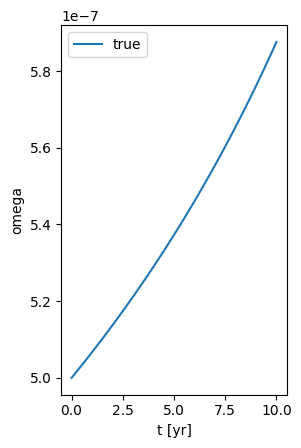

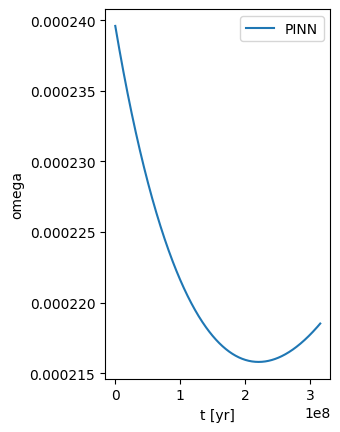

In [17]:
t_eval = torch.linspace(0, 1, 500, dtype=torch.float64).reshape(-1,1)
omega_pred = model(t_eval).detach()

plt.subplot(121)
plt.plot(t_span/yr, omg_arr, label="true")
plt.xlabel("t [yr]")
plt.ylabel("omega")
plt.legend()
plt.show()

plt.subplot(122)
plt.plot(t_eval*(t_max - t_min) + t_min, omega_pred, label="PINN")
plt.xlabel("t [yr]")
plt.ylabel("omega")
plt.legend()
plt.show()
